In [50]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import sys
import time
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
# get_ipython().run_line_magic('matplotlib', 'inline')

sns.color_palette("husl")
sns.set_style('darkgrid')


In [51]:
df1 = pd.read_csv('model_data.csv', index_col=0)

In [52]:
df1.head()

,Media Cost,week_num,SALES,year,holiday,winter,summer,spring,fall,CPI_COMMON,...,m_Impressions/Display,Impressions/Video,v_Impressions/Video,m_Impressions/Video,Impressions/Mobile,v_Impressions/Mobile,m_Impressions/Mobile,Impressions,v_Impressions,m_Impressions
0,0.000000,1,1114553.0,2019,1.0,1.0,0.0,0.0,0.0,1.8,...,0,0.0,0.0,0.0,2431,0,0,3860,0,0
2,0.000000,8,1122487.0,2019,1.0,1.0,0.0,0.0,0.0,1.8,...,1734,0.0,0.0,0.0,2584,1843,2411,4340,2986,4145
4,0.000000,9,1104080.0,2019,0.0,0.0,0.0,1.0,0.0,1.7,...,5102,0.0,0.0,0.0,8842,6425,7631,13991,10204,12733
6,0.000000,10,1074931.0,2019,0.0,0.0,0.0,1.0,0.0,1.7,...,5588,0.0,0.0,0.0,7582,5359,6284,13233,9560,11872
9,331.416836,11,1202179.0,2019,0.0,0.0,0.0,1.0,0.0,1.7,...,5415,18886.0,26.0,31.0,7284,4992,5936,64453,9058,11382


In [53]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108 entries, 0 to 122
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Media Cost             108 non-null    float64
 1   week_num               108 non-null    int64  
 2   SALES                  108 non-null    float64
 3   year                   108 non-null    int64  
 4   holiday                108 non-null    float64
 5   winter                 108 non-null    float64
 6   summer                 108 non-null    float64
 7   spring                 108 non-null    float64
 8   fall                   108 non-null    float64
 9   CPI_COMMON             108 non-null    float64
 10  Impressions/Display    108 non-null    int64  
 11  v_Impressions/Display  108 non-null    int64  
 12  m_Impressions/Display  108 non-null    int64  
 13  Impressions/Video      108 non-null    float64
 14  v_Impressions/Video    108 non-null    float64
 15  m_Impr

# VARIABLES

## Control Variables

In [54]:
# holiday variable
hldy_cols = ['holiday']

In [55]:
# seasonality variables 
seas_cols = ['winter', 'summer', 'spring', 'fall']

In [56]:
# price and CPI_COMMON as macro economic variable
me_cols = ['CPI_COMMON']

In [57]:
# discount as a markdown/discount variable
# mrkdn_cols = ['discount']

In [58]:
# base_vars = me_cols + mrkdn_cols + hldy_cols + seas_cols
base_vars = me_cols + hldy_cols + seas_cols

## Media Variables

In [59]:
df1.columns

Index(['Media Cost', 'week_num', 'SALES', 'year', 'holiday', 'winter',
       'summer', 'spring', 'fall', 'CPI_COMMON', 'Impressions/Display',
       'v_Impressions/Display', 'm_Impressions/Display', 'Impressions/Video',
       'v_Impressions/Video', 'm_Impressions/Video', 'Impressions/Mobile',
       'v_Impressions/Mobile', 'm_Impressions/Mobile', 'Impressions',
       'v_Impressions', 'm_Impressions'],
      dtype='object')

In [60]:
# impressions
mdip_cols = ['Impressions/Display',
       'v_Impressions/Display', 'm_Impressions/Display', 'Impressions/Video',
       'v_Impressions/Video', 'm_Impressions/Video', 'Impressions/Mobile',
       'v_Impressions/Mobile', 'm_Impressions/Mobile', 'Impressions',
       'v_Impressions', 'm_Impressions']

In [61]:
# media cost
mdsp_cols = ['Media Cost']

# Sales Variable

In [62]:
sales_cols =['SALES']

# EDA - correlation, distribution plots

#### **correlation between sales and macro economic variables**

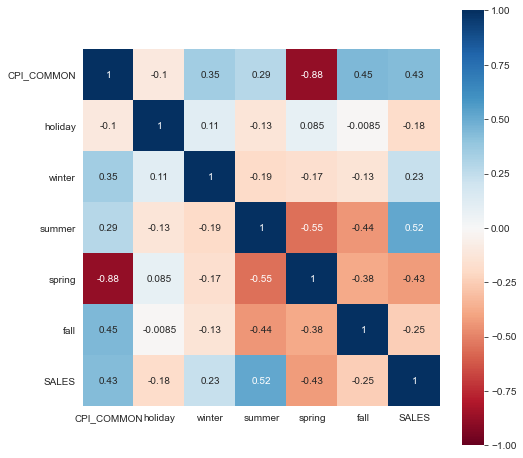

In [63]:
plt.figure(figsize=(8,8))
sns.heatmap(df1[base_vars+['SALES']].corr(), square=True, annot=True, vmax=1, vmin=-1, cmap='RdBu')

## Note that within the basic control variables there are no variables that has negative correlation with SALES. Hence, we don't need X2.

# 2. Model Implementation
### The model is built in a stacked way. Three models are trained:   
### - Control Model
### - Marketing Mix Model
### - Diminishing Return Model    


## 2.1 Control Model / Base Sales Model

In [64]:
!pip install pystan

In [65]:
import pystan
import os

#os.environ['CC'] = 'gcc-10'
#os.environ['CXX'] = 'g++-10'

### Helper functions

In [66]:
from sklearn.metrics import mean_squared_error

In [67]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [68]:
def apply_mean_center(x):
    mu = np.mean(x)
    xm = x/mu
    return xm, mu

In [69]:
def mean_center_transform(df, cols):
    '''
    returns: 
    mean-centered df
    scaler, dict
    '''
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        df_new[col], mu = apply_mean_center(x)
        sc[col] = mu
    return df_new, sc

In [70]:
df1 = df1.replace(to_replace = {'SALES': 0}, value=df1['SALES'].mean())

In [80]:
# mean-centralize: sales, numeric base_vars
df1_ctrl, sc_ctrl = mean_center_transform(df1, ['SALES'] + me_cols)

# df1_ctrl.head()
# df1[hldy_cols+seas_cols].head()
df1_ctrl = pd.concat([df1_ctrl, df1[hldy_cols+seas_cols].reset_index(drop=True)], axis=1)


df1_ctrl

,SALES,CPI_COMMON,holiday,winter,summer,spring,fall
0,0.942154,1.01250,1.0,1.0,0.0,0.0,0.0
1,0.948861,1.01250,1.0,1.0,0.0,0.0,0.0
2,0.933301,0.95625,0.0,0.0,0.0,1.0,0.0
3,0.908661,0.95625,0.0,0.0,0.0,1.0,0.0
4,1.016226,0.95625,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
103,1.034091,1.06875,0.0,0.0,0.0,0.0,1.0
104,0.953819,1.06875,0.0,1.0,0.0,0.0,0.0
105,1.071671,1.06875,0.0,1.0,0.0,0.0,0.0
106,1.207325,1.06875,0.0,1.0,0.0,0.0,0.0


In [83]:
# variables positively related to sales: macro economy, markdown, holiday
pos_vars = ['CPI_COMMON']
X1 = df1_ctrl[pos_vars].to_numpy()

#### X1: a numpy array with values of the pos_vars mean-centralized

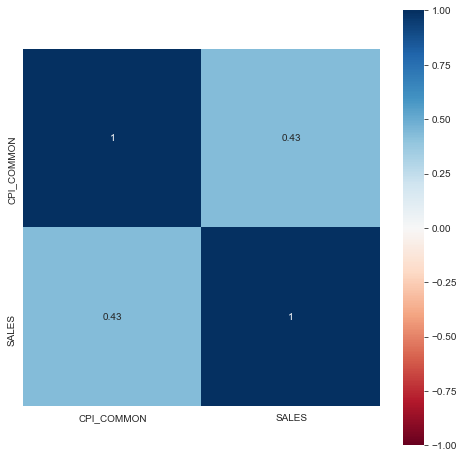

In [84]:
plt.figure(figsize=(8,8))
sns.heatmap(df1[pos_vars + ['SALES']].corr(), square=True, annot=True, vmax=1, vmin=-1, cmap='RdBu')

In [87]:
# variables that may have either positive or negtive impact on sales: seasonality
pn_vars = hldy_cols + seas_cols
X2 = df1_ctrl[pn_vars].values

In [92]:
X1

array([[1.0125 ],
       [1.0125 ],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [0.95625],
       [1.0125 ],
       [1.0125 ],
       [1.0125 ],
       [1.0125 ],
       [1.0125 ],
       [1.0125 ],
       [1.0125 ],
       [1.0125 ],
       [1.0125 ],
       [1.0125 ],
       [1.0125 ],
       [1.0125 ],
       [1.0125 ],
       [1.0125 ],
       [1.0125 ],
       [1.0125 ],
       [1.0125 ],
       [1.0125 ],
       [1.

In [88]:
df1['SALES'].describe()

count    1.080000e+02
mean     1.182984e+06
std      9.259401e+04
min      1.022683e+06
25%      1.114496e+06
50%      1.185014e+06
75%      1.238513e+06
max      1.564033e+06
Name: SALES, dtype: float64

#### X2: a numpy array with values of the pn_vars mean-centralized

In [93]:
ctrl_data = {
    'N': len(df1_ctrl),
    'K1': len(pos_vars), 
    'K2': len(pn_vars), 
    'X1': X1,
    'X2': X2, 
    'y': df1_ctrl['SALES'].values,
    'max_intercept': min(df1_ctrl['SALES'])
}


In [94]:
ctrl_code1 = '''
data {
  int N; // number of observations
  int K1; // number of positive predictors
  int K2; // number of positive/negative predictors
  real max_intercept; // restrict the intercept to be less than the minimum y
  matrix[N, K1] X1;
  matrix[N, K2] X2;
  vector[N] y; 
}
parameters {
  vector<lower=0>[K1] beta1; // regression coefficients for X1 (positive)
  vector[K2] beta2; // regression coefficients for X2
  real<lower=0, upper=max_intercept> alpha; // intercept
  real<lower=0> noise_var; // residual variance
}
model {
  // Define the priors
  beta1 ~ normal(0, 1); 
  beta2 ~ normal(0, 1); 
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  // The likelihood
  y ~ normal(X1*beta1 + X2*beta2 + alpha, sqrt(noise_var));
}
'''

sm1 = pystan.StanModel(model_code=ctrl_code1, verbose=True)
fit1 = sm1.sampling(data=ctrl_data, iter=2000, chains=4)
fit1_result = fit1.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a396b59aabedfaa132f3a814776a219f NOW.
INFO:pystan:OS: win32, Python: 3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)], Cython 0.29.21
Compiling C:\Users\BENWAN~1\AppData\Local\Temp\pystan_rh415b_1\stanfit4anon_model_a396b59aabedfaa132f3a814776a219f_1126090762387397921.pyx because it changed.
[1/1] Cythonizing C:\Users\BENWAN~1\AppData\Local\Temp\pystan_rh415b_1\stanfit4anon_model_a396b59aabedfaa132f3a814776a219f_1126090762387397921.pyx
building 'stanfit4anon_model_a396b59aabedfaa132f3a814776a219f_1126090762387397921' extension
D:\ANACONDA\Library\mingw-w64\bin\gcc.exe -mdll -O -Wall -DMS_WIN64 -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -IC:\Users\BENWAN~1\AppData\Local\Temp\pystan_rh415b_1 -ID:\ANACONDA\lib\site-packages\pystan -ID:\ANACONDA\lib\site-packages\pystan\stan\src -ID:\ANACONDA\lib\site-packages\pystan\stan\lib\stan_math -ID:\ANACONDA\lib\site-packages\pystan\stan\lib\stan_ma

In [95]:
# extract control model parameters and predict base sales -> df['base_sales']
def extract_ctrl_model(fit_result, pos_vars=pos_vars, pn_vars=pn_vars, 
                       extract_param_list=False):
    ctrl_model = {}
    ctrl_model['pos_vars'] = pos_vars
    ctrl_model['pn_vars'] = pn_vars
    ctrl_model['beta1'] = fit_result['beta1'].mean(axis=0).tolist()
    ctrl_model['beta2'] = fit_result['beta2'].mean(axis=0).tolist()
    ctrl_model['alpha'] = fit_result['alpha'].mean()
    if extract_param_list:
        ctrl_model['beta1_list'] = fit_result['beta1'].tolist()
        ctrl_model['beta2_list'] = fit_result['beta2'].tolist()
        ctrl_model['alpha_list'] = fit_result['alpha'].tolist()
    return ctrl_model

def ctrl_model_predict(ctrl_model, df):
    pos_vars, pn_vars = ctrl_model['pos_vars'], ctrl_model['pn_vars'] 
    X1, X2 = df[pos_vars], df[pn_vars]
    beta1, beta2 = np.array(ctrl_model['beta1']), np.array(ctrl_model['beta2'])
    alpha = ctrl_model['alpha']
    y_pred = np.dot(X1, beta1) + np.dot(X2, beta2) + alpha
    return y_pred

base_sales_model = extract_ctrl_model(fit1_result, pos_vars=['CPI_COMMON'], pn_vars=pn_vars)
base_sales = ctrl_model_predict(base_sales_model, df1_ctrl)
df1['base_sales'] = base_sales*sc_ctrl['SALES']
# evaluate control model
print('mape: ', mean_absolute_percentage_error(df1['SALES'], df1['base_sales']))

mape:  4.50654766827674


# **2.2 Marketing Mix Model**

### **Adstock Transformations**

In [96]:
def mean_log1p_trandform(df, cols):
    '''
    returns: 
    mean-centered, log1p transformed df
    scaler, dict
    '''
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        xm, mu = apply_mean_center(x)
        sc[col] = mu
        df_new[col] = np.log1p(xm)
    return df_new, sc

import json

def save_json(data, file_name):
    with open(file_name, 'w') as fp:
        json.dump(data, fp)

def load_json(file_name):
    with open(file_name, 'r') as fp:
        data = json.load(fp)
    return data

In [97]:
def apply_adstock(x, L, P, D):
    '''
    params:
    x: original media variable, array
    L: length
    P: peak, delay in effect
    D: decay, retain rate
    returns:
    array, adstocked media variable
    '''
    x = np.append(np.zeros(L-1), x)
    
    weights = np.zeros(L)
    for l in range(L):
        weight = D**((l-P)**2)
        weights[L-1-l] = weight
    
    adstocked_x = []
    for i in range(L-1, len(x)):
        x_array = x[i-L+1:i+1]
        xi = sum(x_array * weights)/sum(weights)
        adstocked_x.append(xi)
    adstocked_x = np.array(adstocked_x)
    return adstocked_x

In [98]:
def adstock_transform(df, md_cols, adstock_params):
    '''
    params:
    df: original data
    md_cols: list, media variables to be transformed
    adstock_params: dict, 
        e.g., {'sem': {'L': 8, 'P': 0, 'D': 0.1}, 'dm': {'L': 4, 'P': 1, 'D': 0.7}}
    returns: 
    adstocked df
    '''
    md_df = pd.DataFrame()
    for md_col in md_cols:
        md = md_col.split('_')[-1]
        L, P, D = adstock_params[md]['L'], adstock_params[md]['P'], adstock_params[md]['D']
        xa = apply_adstock(df[md_col].values, L, P, D)
        md_df[md_col] = xa
    return md_df

In [99]:
# 2.2 Marketing Mix Model
df_mmm, sc_mmm = mean_log1p_trandform(df1, ['SALES', 'base_sales'])
mu_mdip = df1[mdip_cols].apply(np.mean, axis=0).values
max_lag = 8
num_media = len(mdip_cols)
# padding zero * (max_lag-1) rows
X_media = np.concatenate((np.zeros((max_lag-1, num_media)), df1[mdip_cols].values), axis=0)
X_ctrl = df_mmm['base_sales'].values.reshape(len(df1),1)
model_data2 = {
    'N': len(df1),
    'max_lag': max_lag, 
    'num_media': num_media,
    'X_media': X_media, 
    'mu_mdip': mu_mdip,
    'num_ctrl': X_ctrl.shape[1],
    'X_ctrl': X_ctrl, 
    'y': df_mmm['SALES'].values
}



In [100]:
model_code2 = '''
functions {
  // the adstock transformation with a vector of weights
  real Adstock(vector t, row_vector weights) {
    return dot_product(t, weights) / sum(weights);
  }
}
data {
  // the total number of observations
  int<lower=1> N;
  // the vector of sales
  real y[N];
  // the maximum duration of lag effect, in weeks
  int<lower=1> max_lag;
  // the number of media channels
  int<lower=1> num_media;
  // matrix of media variables
  matrix[N+max_lag-1, num_media] X_media;
  // vector of media variables' mean
  real mu_mdip[num_media];
  // the number of other control variables
  int<lower=1> num_ctrl;
  // a matrix of control variables
  matrix[N, num_ctrl] X_ctrl;
}
parameters {
  // residual variance
  real<lower=0> noise_var;
  // the intercept
  real tau;
  // the coefficients for media variables and base sales
  vector<lower=0>[num_media+num_ctrl] beta;
  // the decay and peak parameter for the adstock transformation of
  // each media
  vector<lower=0,upper=1>[num_media] decay;
  vector<lower=0,upper=ceil(max_lag/2)>[num_media] peak;
}
transformed parameters {
  // the cumulative media effect after adstock
  real cum_effect;
  // matrix of media variables after adstock
  matrix[N, num_media] X_media_adstocked;
  // matrix of all predictors
  matrix[N, num_media+num_ctrl] X;
  
  // adstock, mean-center, log1p transformation
  row_vector[max_lag] lag_weights;
  for (nn in 1:N) {
    for (media in 1 : num_media) {
      for (lag in 1 : max_lag) {
        lag_weights[max_lag-lag+1] <- pow(decay[media], (lag - 1 - peak[media]) ^ 2);
      }
     cum_effect <- Adstock(sub_col(X_media, nn, media, max_lag), lag_weights);
     X_media_adstocked[nn, media] <- log1p(cum_effect/mu_mdip[media]);
    }
  X <- append_col(X_media_adstocked, X_ctrl);
  } 
}
model {
  decay ~ beta(3,3);
  peak ~ uniform(0, ceil(max_lag/2));
  tau ~ normal(0, 5);
  for (i in 1 : num_media+num_ctrl) {
    beta[i] ~ normal(0, 1);
  }
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  y ~ normal(tau + X * beta, sqrt(noise_var));
}
'''

sm2 = pystan.StanModel(model_code=model_code2, verbose=True)
fit2 = sm2.sampling(data=model_data2, iter=1000, chains=3)
fit2_result = fit2.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c6677ffefdee0513f144508ee1783d0c NOW.
INFO:pystan:OS: win32, Python: 3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)], Cython 0.29.21
Compiling C:\Users\BENWAN~1\AppData\Local\Temp\pystan_w7h6rty5\stanfit4anon_model_c6677ffefdee0513f144508ee1783d0c_1388315275182432841.pyx because it changed.
[1/1] Cythonizing C:\Users\BENWAN~1\AppData\Local\Temp\pystan_w7h6rty5\stanfit4anon_model_c6677ffefdee0513f144508ee1783d0c_1388315275182432841.pyx
building 'stanfit4anon_model_c6677ffefdee0513f144508ee1783d0c_1388315275182432841' extension
D:\ANACONDA\Library\mingw-w64\bin\gcc.exe -mdll -O -Wall -DMS_WIN64 -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -IC:\Users\BENWAN~1\AppData\Local\Temp\pystan_w7h6rty5 -ID:\ANACONDA\lib\site-packages\pystan -ID:\ANACONDA\lib\site-packages\pystan\stan\src -ID:\ANACONDA\lib\site-packages\pystan\stan\lib\stan_math -ID:\ANACONDA\lib\site-packages\pystan\stan\lib\stan_ma

## **Extract mmm parameters**

In [101]:
# extract mmm parameters
def extract_mmm(fit_result, max_lag=max_lag, 
                media_vars=mdip_cols, ctrl_vars=['base_sales'], 
                extract_param_list=True):
    mmm = {}
    
    mmm['max_lag'] = max_lag
    mmm['media_vars'], mmm['ctrl_vars'] = media_vars, ctrl_vars
    mmm['decay'] = decay = fit_result['decay'].mean(axis=0).tolist()
    mmm['peak'] = peak = fit_result['peak'].mean(axis=0).tolist()
    mmm['beta'] = fit_result['beta'].mean(axis=0).tolist()
    mmm['tau'] = fit_result['tau'].mean()
    if extract_param_list:
        mmm['decay_list'] = fit_result['decay'].tolist()
        mmm['peak_list'] = fit_result['peak'].tolist()
        mmm['beta_list'] = fit_result['beta'].tolist()
        mmm['tau_list'] = fit_result['tau'].tolist()
    
    adstock_params = {}
    media_names = [col.replace('mdip_', '') for col in media_vars]
    for i in range(len(media_names)):
        adstock_params[media_names[i]] = {
            'L': max_lag,
            'P': peak[i],
            'D': decay[i]
        }
    mmm['adstock_params'] = adstock_params
    return mmm

mmm = extract_mmm(fit2, max_lag=max_lag, 
                media_vars=mdip_cols, ctrl_vars=['base_sales'])
# Save mmm json
save_json(mmm, 'mmm1.json')

### **plot media coefficients' distributions**
### **red line: mean, green line: median**

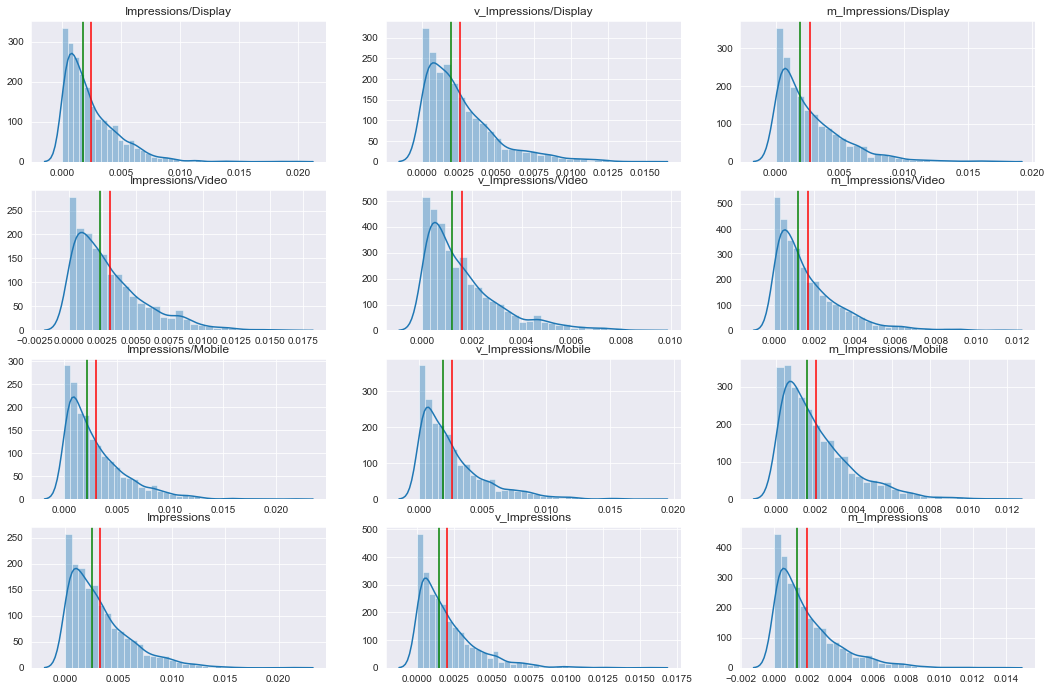

In [102]:
# extract mmm parameters
def extract_mmm(fit_result, max_lag=max_lag, 
                media_vars=mdip_cols, ctrl_vars=['base_sales'], 
                extract_param_list=True):
    mmm = {}
    
    mmm['max_lag'] = max_lag
    mmm['media_vars'], mmm['ctrl_vars'] = media_vars, ctrl_vars
    mmm['decay'] = decay = fit_result['decay'].mean(axis=0).tolist()
    mmm['peak'] = peak = fit_result['peak'].mean(axis=0).tolist()
    mmm['beta'] = fit_result['beta'].mean(axis=0).tolist()
    mmm['tau'] = fit_result['tau'].mean()
    if extract_param_list:
        mmm['decay_list'] = fit_result['decay'].tolist()
        mmm['peak_list'] = fit_result['peak'].tolist()
        mmm['beta_list'] = fit_result['beta'].tolist()
        mmm['tau_list'] = fit_result['tau'].tolist()
    
    adstock_params = {}
    media_names = [col.replace('mdip_', '') for col in media_vars]
    for i in range(len(media_names)):
        adstock_params[media_names[i]] = {
            'L': max_lag,
            'P': peak[i],
            'D': decay[i]
        }
    mmm['adstock_params'] = adstock_params
    return mmm

mmm = extract_mmm(fit2, max_lag=max_lag, 
                media_vars=mdip_cols, ctrl_vars=['base_sales'])
# save_json(mmm, 'mmm1.json')


# plot media coefficients' distributions
# red line: mean, green line: median
beta_media = {}
for i in range(len(mmm['media_vars'])):
    md = mmm['media_vars'][i]
    betas = []
    for j in range(len(mmm['beta_list'])):
        betas.append(mmm['beta_list'][j][i])
    beta_media[md] = np.array(betas)

f = plt.figure(figsize=(18,15))
for i in range(len(mmm['media_vars'])):
    ax = f.add_subplot(5,3,i+1)
    md = mmm['media_vars'][i]
    x = beta_media[md]
    mean_x = x.mean()
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-')
    ax.axvline(median_x, color='g', linestyle='-')
    ax.set_title(md)

## **Decompose sales to media channels' contribution**
## **Each media channel's contribution = total sales - sales upon removal the channel** 

In [103]:
# decompose sales to media contribution
def mmm_decompose_contrib(mmm, df1, original_sales=df1['SALES']):
    # adstock params
    adstock_params = mmm['adstock_params']
    # coefficients, intercept
    beta, tau = mmm['beta'], mmm['tau']
    # variables
    media_vars, ctrl_vars = mmm['media_vars'], mmm['ctrl_vars']
    num_media, num_ctrl = len(media_vars), len(ctrl_vars)
    # X_media2: adstocked, mean-centered media variables + 1
    X_media2 = adstock_transform(df1, media_vars, adstock_params)
    X_media2, sc_mmm2 = mean_center_transform(X_media2, media_vars)
    X_media2 = X_media2 + 1
    # X_ctrl2, mean-centered control variables + 1
    X_ctrl2, sc_mmm2_1 = mean_center_transform(df1[ctrl_vars], ctrl_vars)
    X_ctrl2 = X_ctrl2 + 1
    # y_true2, mean-centered sales variable + 1
    y_true2, sc_mmm2_2 = mean_center_transform(df1, ['SALES'])
    y_true2 = y_true2 + 1
    sc_mmm2.update(sc_mmm2_1)
    sc_mmm2.update(sc_mmm2_2)
    # X2 <- media variables + ctrl variable
    X2 = pd.concat([X_media2, X_ctrl2], axis=1)

    # 1. compute each media/control factor: 
    # log-log model: log(sales) = log(X[0])*beta[0] + ... + log(X[13])*beta[13] + tau
    # multiplicative model: sales = X[0]^beta[0] * ... * X[13]^beta[13] * e^tau
    # each factor = X[i]^beta[i]
    # intercept = e^tau
    factor_df = pd.DataFrame(columns=media_vars+ctrl_vars+['intercept'])
    for i in range(num_media):
        colname = media_vars[i]
        factor_df[colname] = X2[colname] ** beta[i]
    for i in range(num_ctrl):
        colname = ctrl_vars[i]
        factor_df[colname] = X2[colname] ** beta[num_media+i]
    factor_df['intercept'] = np.exp(tau)

    # 2. calculate the product of all factors -> y_pred
    # baseline = intercept * control factor = e^tau * X[13]^beta[13]
    y_pred = factor_df.apply(np.prod, axis=1)
    factor_df['y_pred'], factor_df['y_true2'] = y_pred, y_true2
    factor_df['baseline'] = factor_df[['intercept']+ctrl_vars].apply(np.prod, axis=1)

    # 3. calculate each media factor's contribution
    # media contribution = total volume – volume upon removal of the media factor
    mc_df = pd.DataFrame(columns=media_vars+['baseline'])
    for col in media_vars:
        mc_df[col] = factor_df['y_true2'] - factor_df['y_true2']/factor_df[col]
    mc_df['baseline'] = factor_df['baseline']
    mc_df['y_true2'] = factor_df['y_true2']

    # 4. scale contribution
    # predicted total media contribution: product of all media factors
    mc_df['mc_pred'] = mc_df[media_vars].apply(np.sum, axis=1)
    # true total media contribution: total volume - baseline
    mc_df['mc_true'] = mc_df['y_true2'] - mc_df['baseline']
    # predicted total media contribution is slightly different from true total media contribution
    # scale each media factor’s contribution by removing the delta volume proportionally
    mc_df['mc_delta'] =  mc_df['mc_pred'] - mc_df['mc_true']
    for col in media_vars:
        mc_df[col] = mc_df[col] - mc_df['mc_delta']*mc_df[col]/mc_df['mc_pred']

    # 5. scale mc_df based on original sales
    mc_df['sales'] = original_sales
    for col in media_vars+['baseline']:
        mc_df[col] = mc_df[col]*mc_df['sales']/mc_df['y_true2']
    
    print('rmse (log-log model): ', 
         mean_squared_error(np.log(y_true2), np.log(y_pred)) ** (1/2))
    print('mape (multiplicative model): ', 
         mean_absolute_percentage_error(y_true2, y_pred))
    return mc_df

#### **calculate media contribution percentage**

In [146]:
# calculate media contribution percentage
def calc_media_contrib_pct(mc_df, media_vars=mdip_cols, sales_col='sales', period=52):
    '''
    returns:
    mc_pct: percentage over total sales
    mc_pct2: percentage over incremental sales (sales contributed by media channels)
    '''
    mc_pct = {}
    mc_pct2 = {}
    s = 0
    if period is None:
        for col in (media_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[sales_col]).mean()
    else:
        for col in (media_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[sales_col])[-period:].mean()
    for m in media_vars:
        s += mc_pct[m]
    for m in media_vars:
        mc_pct2[m] = mc_pct[m]/s
    return mc_pct, mc_pct2

mc_df = mmm_decompose_contrib(mmm, df1, original_sales=df1['SALES']).fillna(0)
for col in mdip_cols:
    mc_df[col] = mc_df.replace({col: 0},  mc_df.mean())
adstock_params = mmm['adstock_params']
mc_pct, mc_pct2 = calc_media_contrib_pct(mc_df, period=52)

rmse (log-log model):  0.03044451319112684
mape (multiplicative model):  3.7649910328039873


In [147]:
mc_df

,Impressions/Display,v_Impressions/Display,m_Impressions/Display,Impressions/Video,v_Impressions/Video,m_Impressions/Video,Impressions/Mobile,v_Impressions/Mobile,m_Impressions/Mobile,Impressions,v_Impressions,m_Impressions,baseline,y_true2,mc_pred,mc_true,mc_delta,sales
0,-13074.204213,-13074.204213,-13074.204213,-13074.204213,-13074.204213,-13074.204213,-13074.204213,-13074.204213,-13074.204213,-13074.204213,-13074.204213,-13074.204213,1.144342e+06,1.942154,0.000013,-0.051908,0.051921,1114553.0
1,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,0.000000e+00,1.948861,0.000251,-0.045201,0.045452,0.0
2,-123.987657,-123.987657,-123.987657,-123.987657,-123.987657,-123.987657,-123.987657,-123.987657,-123.987657,-123.987657,-123.987657,-123.987657,1.123927e+06,1.933301,0.001766,-0.002480,0.004245,1122487.0
3,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,0.000000e+00,1.908661,0.005865,-0.027120,0.032985,0.0
4,2484.339915,2484.339915,2484.339915,2484.339915,2484.339915,2484.339915,2484.339915,2484.339915,2484.339915,2484.339915,2484.339915,2484.339915,1.060028e+06,2.016226,0.011601,0.080445,-0.068845,1104080.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,5205.922155,5205.922155,5205.922155,5205.922155,5205.922155,5205.922155,5205.922155,5205.922155,5205.922155,5205.922155,5205.922155,5205.922155,1.067605e+06,2.034091,0.053521,0.057524,-0.004003,1098675.0
104,-9448.335309,-9448.335309,-9448.335309,-9448.335309,-9448.335309,-9448.335309,-9448.335309,-9448.335309,-9448.335309,-9448.335309,-9448.335309,-9448.335309,1.159642e+06,1.953819,0.045639,-0.100070,0.145709,1103142.0
105,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,1832.930267,0.000000e+00,2.071671,0.029243,0.017782,0.011461,0.0
106,14063.569187,14063.569187,14063.569187,14063.569187,14063.569187,14063.569187,14063.569187,14063.569187,14063.569187,14063.569187,14063.569187,14063.569187,1.036133e+06,2.207325,0.008673,0.153436,-0.144763,1113538.0


In [148]:
mc_df.to_csv('mc_df1.csv', index=False)
save_json(adstock_params, 'adstock_params1.json')
pd.concat([
     pd.DataFrame.from_dict(mc_pct, orient='index', columns=['mc_pct']),
     pd.DataFrame.from_dict(mc_pct2, orient='index', columns=['mc_pct2'])
], axis=1).to_csv('mc_pct_df1.csv')

###  **2.3 Diminishing Return Model**    

In [149]:
mdip_cols

['Impressions/Display',
 'v_Impressions/Display',
 'm_Impressions/Display',
 'Impressions/Video',
 'v_Impressions/Video',
 'm_Impressions/Video',
 'Impressions/Mobile',
 'v_Impressions/Mobile',
 'm_Impressions/Mobile',
 'Impressions',
 'v_Impressions',
 'm_Impressions']

In [150]:
mc_df['Impressions/Display'] / mc_df['Impressions/Display'].mean()

0     -6.528465
1      0.915254
2     -0.061912
3      0.915254
4      1.240529
         ...   
103    2.599522
104   -4.717926
105    0.915254
106    7.022494
107    0.915254
Name: Impressions/Display, Length: 108, dtype: float64

In [153]:
# 2.3 Diminishing Return Model    
def create_hill_model_data(df, mc_df, adstock_params, media):
    # y = mc_df['mdip_'+media].values
    y = mc_df[media].values
    L, P, D = adstock_params[media]['L'], adstock_params[media]['P'], adstock_params[media]['D']
    # x = df['mdsp_'+media].values
    x = df[media].values
    x_adstocked = apply_adstock(x, L, P, D)
    # centralize
    mu_x, mu_y = x_adstocked.mean(), y.mean()
    sc = {'x': mu_x, 'y': mu_y}
    x = x_adstocked/mu_x
    y = y/mu_y
        
    model_data = {
        'N': len(y),
        'y': y,
        'X': x
    }
    print(y)
    return model_data, sc

model_code3 = '''
functions {
  // the Hill function
  real Hill(real t, real ec, real slope) {
  return 1 / (1 + (t / ec)^(-slope));
  }
}

data {
  // the total number of observations
  int<lower=1> N;
  // y: vector of media contribution
  vector[N] y;
  // X: vector of adstocked media spending
  vector[N] X;
}

parameters {
  // residual variance
  real<lower=0> noise_var;
  // regression coefficient
  real<lower=0> beta_hill;
  // ec50 and slope for Hill function of the media
  real<lower=0,upper=1> ec;
  real<lower=0> slope;
}

transformed parameters {
  // a vector of the mean response
  vector[N] mu;
  for (i in 1:N) {
    mu[i] <- beta_hill * Hill(X[i], ec, slope);
  }
}

model {
  slope ~ gamma(3, 1);
  ec ~ beta(2, 2);
  beta_hill ~ normal(0, 1);
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01); 
  y ~ normal(mu, sqrt(noise_var));
}
'''

#### **pipeline for training one hill model for a media channel**

In [154]:
# pipeline for training one hill model for a media channel
def train_hill_model(df, mc_df, adstock_params, media, sm):
    '''
    params:
    df: original data
    mc_df: media contribution df derived from MMM
    adstock_params: adstock parameter dict output by MMM
    media: 'dm', 'inst', 'nsp', 'auddig', 'audtr', 'vidtr', 'viddig', 'so', 'on', 'sem'
    sm: stan model object    
    returns:
    a dict of model data, scaler, parameters
    '''
    data, sc = create_hill_model_data(df, mc_df, adstock_params, media)
    fit = sm.sampling(data=data, iter=2000, chains=4)
    fit_result = fit.extract()
    hill_model = {
        'beta_hill_list': fit_result['beta_hill'].tolist(),
        'ec_list': fit_result['ec'].tolist(),
        'slope_list': fit_result['slope'].tolist(),
        'sc': sc,
        'data': {
            'X': data['X'].tolist(),
            'y': data['y'].tolist(),
        }
    }
    return hill_model

# extract params by mean or median
# almost no difference, choose either one
def extract_hill_model_params(hill_model, method='mean'):
    if method=='mean':
        hill_model_params = {
            'beta_hill': np.mean(hill_model['beta_hill_list']), 
            'ec': np.mean(hill_model['ec_list']), 
            'slope': np.mean(hill_model['slope_list'])
        }
    elif method=='median':
        hill_model_params = {
            'beta_hill': np.median(hill_model['beta_hill_list']), 
            'ec': np.median(hill_model['ec_list']), 
            'slope': np.median(hill_model['slope_list'])
        }
    return hill_model_params

def hill_model_predict(hill_model_params, x):
    beta_hill, ec, slope = hill_model_params['beta_hill'], hill_model_params['ec'], hill_model_params['slope']
    y_pred = beta_hill * hill_transform(x, ec, slope)
    return y_pred

def evaluate_hill_model(hill_model, hill_model_params):
    x = np.asarray(hill_model['data']['X'])
    y_true = np.asarray(hill_model['data']['y']) * hill_model['sc']['y']
    y_pred = hill_model_predict(hill_model_params, x) * hill_model['sc']['y']
    print('mape on original data: ', 
         mean_absolute_percentage_error(y_true, y_pred))
    return y_true, y_pred

In [155]:
# train hill models for all media channels
sm3 = pystan.StanModel(model_code=model_code3, verbose=True)
hill_models = {}
# to_train = ['dm', 'inst', 'nsp', 'auddig', 'audtr', 'vidtr', 'viddig', 'so', 'on', 'sem']
to_train = mdip_cols
for media in to_train:
    print('training for media: ', media)
    hill_model = train_hill_model(df1, mc_df, adstock_params, media, sm3)
    print("trained for media: ", media)
    hill_models[media] = hill_model

ons/Display
training for media:  m_Impressions/Display
[-6.52846484e+00  9.15254237e-01 -6.19119183e-02  9.15254237e-01
  1.24052872e+00  9.15254237e-01  3.38494729e+00  9.15254237e-01
  9.15254237e-01 -2.18777401e+00 -3.83957286e+00 -3.57994605e+00
 -2.77955948e+00  2.93037887e+00  2.84831963e+00  2.72346283e+00
  3.13240611e+00  3.08578669e+00  3.48074939e+00  4.25702996e+00
  4.27707029e+00  4.28828738e+00 -3.45618387e+00 -3.23430713e+00
 -2.96947802e+00 -1.68020899e-02 -1.71864516e-02 -1.54945172e-02
  2.03258094e+00  1.94956420e+00  1.94259317e+00  7.84811922e-01
  7.79420280e-01  8.25123023e-01  9.60571109e-01  8.31766070e-01
  6.70044838e-01 -3.64462298e-02 -3.20918056e-02 -2.90331748e-02
  6.30317102e-01  6.11321526e-01  6.16882884e-01  1.00369464e+00
  1.09731038e+00  1.34633641e+00  2.63168150e+00  2.53611809e+00
  2.28165254e+00  4.87202036e-01  4.92110467e-01  5.33401345e-01
  1.53742954e+00  1.34987257e+00  7.74532562e-01 -2.09946500e-01
 -4.91580761e-01 -7.79609033e-01  1

In [157]:


# 1.2 Diminishing Return
def hill_transform(x, ec, slope):
    return 1 / (1 + (x / ec)**(-slope))

In [158]:


# extract params by mean
hill_model_params_mean, hill_model_params_med = {}, {}
for md in list(hill_models.keys()):
    print("extracting " + md)
    hill_model = hill_models[md]
    params1 = extract_hill_model_params(hill_model, method='mean')
    params1['sc'] = hill_model['sc']
    hill_model_params_mean[md] = params1
#     params2 = extract_hill_model_params(hill_model, method='median')
#     params2['sc'] = hill_model['sc']
#     hill_model_params_med[md] = params2
# save_json(hill_model_params_med, 'hill_model_params_med.json')
# save_json(hill_model_params_mean, 'hill_model_params_mean.json')

# evaluate model params extracted by mean
for md in list(hill_models.keys()):
    print('evaluating media: ', md)
    hill_model = hill_models[md]
    hill_model_params = hill_model_params_mean[md]
    _ = evaluate_hill_model(hill_model, hill_model_params)
# evaluate model params extracted by median
# for md in list(hill_models.keys()):
#     print('evaluating media: ', md)
#     hill_model = hill_models[md]
#     hill_model_params = hill_model_params_med[md]
#     _ = evaluate_hill_model(hill_model, hill_model_params)

extracting Impressions/Display
extracting v_Impressions/Display
extracting m_Impressions/Display
extracting Impressions/Video
extracting v_Impressions/Video
extracting m_Impressions/Video
extracting Impressions/Mobile
extracting v_Impressions/Mobile
extracting m_Impressions/Mobile
extracting Impressions
extracting v_Impressions
extracting m_Impressions
evaluating media:  Impressions/Display
mape on original data:  406.68931064277257
evaluating media:  v_Impressions/Display
mape on original data:  298.47681090384657
evaluating media:  m_Impressions/Display
mape on original data:  306.06724084113625
evaluating media:  Impressions/Video
mape on original data:  322.12305748364605
evaluating media:  v_Impressions/Video
mape on original data:  288.0365368900144
evaluating media:  m_Impressions/Video
mape on original data:  291.3293105096599
evaluating media:  Impressions/Mobile
mape on original data:  372.47447128205124
evaluating media:  v_Impressions/Mobile
mape on original data:  300.8716

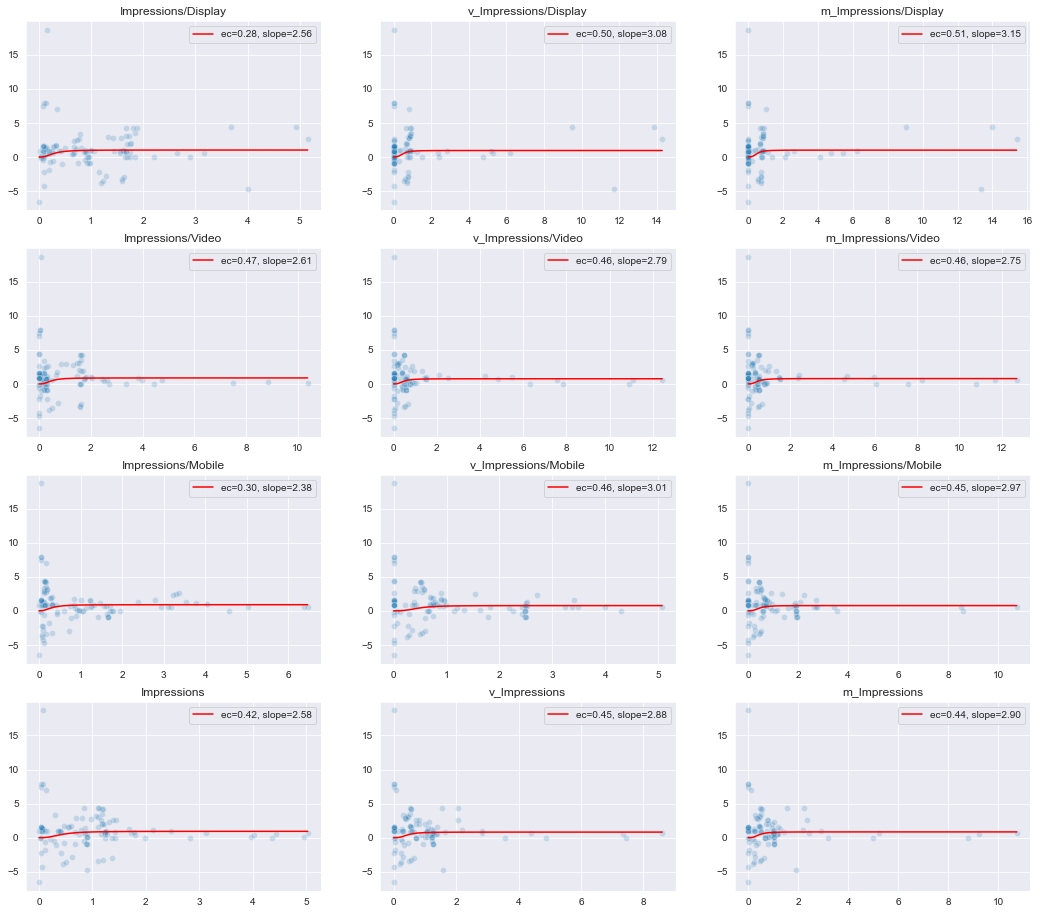

In [159]:
# plot fitted hill function
f = plt.figure(figsize=(18,16))
hm_keys = list(hill_models.keys())
for i in range(len(hm_keys)):
    ax = f.add_subplot(4,3,i+1)
    md = hm_keys[i]
    hm = hill_models[md]
    hmp = hill_model_params_mean[md]
    x, y = hm['data']['X'], hm['data']['y']
    #mu_x, mu_y = hm['sc']['x'], hm['sc']['y']
    ec, slope = hmp['ec'], hmp['slope']
    x_sorted = np.array(sorted(x))
    y_fit = hill_model_predict(hmp, x_sorted)
    ax = sns.scatterplot(x=x, y=y, alpha=0.2)
    ax = sns.lineplot(x=x_sorted, y=y_fit, color='r', 
                 label='ec=%.2f, slope=%.2f'%(ec, slope))
    ax.set_title(md)

,roas_mean,roas_median,mroas,roas_avg
Impressions/Display,4.818611e-01,0.093569,0.018096,0.095896
Impressions/Video,1.034105e+10,0.017348,0.004231,0.044336
Impressions/Mobile,7.096894e-01,0.023777,0.005759,0.064122
Impressions,2.089486e-01,0.011750,0.003206,0.020589
v_Impressions/Display,NaN,NaN,0.005833,NaN
m_Impressions/Display,NaN,NaN,0.002620,NaN
v_Impressions/Video,NaN,NaN,0.110806,NaN
m_Impressions/Video,NaN,NaN,0.108426,NaN
v_Impressions/Mobile,NaN,NaN,0.009534,NaN
m_Impressions/Mobile,NaN,NaN,0.012301,NaN


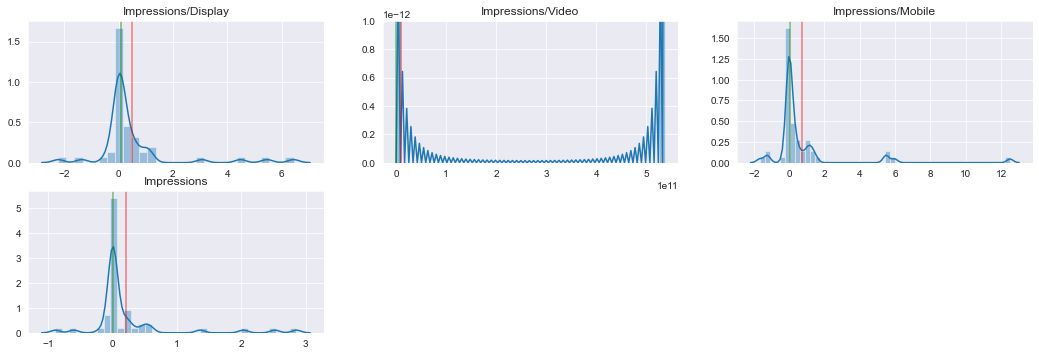

In [162]:
# Calculate overall ROAS and weekly ROAS
# - Overall ROAS = total contribution / total spending
# - Weekly ROAS = weekly contribution / weekly spending

# adstocked media spending
ms_df = pd.DataFrame()
for md in list(hill_models.keys()):
    hill_model = hill_models[md]
    x = np.array(hill_model['data']['X']) * hill_model['sc']['x']
    ms_df[md] = x
    # ms_df['mdsp_'+md] = x
# ms_df.to_csv('ms_df1.csv', index=False)

# calc overall ROAS of a given period
def calc_roas(mc_df, ms_df, period=None):
    roas = {}
    md_names = [col.split('_')[-1] for col in ms_df.columns]
    for i in range(len(md_names)):
        md = md_names[i]
        sp, mc = ms_df[md], mc_df[md]
        # sp, mc = ms_df['mdsp_'+md], mc_df['mdip_'+md]
        if period is None:
            md_roas = mc.sum()/sp.sum()
        else:
            md_roas = mc[-period:].sum()/sp[-period:].sum()
        roas[md] = md_roas
    return roas

# calc weekly ROAS
def calc_weekly_roas(mc_df, ms_df):
    weekly_roas = pd.DataFrame()
    md_names = [col.split('_')[-1] for col in ms_df.columns]
    for md in md_names:
        weekly_roas[md] = mc_df[md]/ms_df[md]
        # weekly_roas[md] = mc_df['mdip_'+md]/ms_df['mdsp_'+md]
    weekly_roas.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    return weekly_roas

roas_1y = calc_roas(mc_df, ms_df, period=52)
weekly_roas = calc_weekly_roas(mc_df, ms_df)
roas1y_df = pd.DataFrame(index=weekly_roas.columns.tolist())
roas1y_df['roas_mean'] = weekly_roas[-52:].apply(np.mean, axis=0)
roas1y_df['roas_median'] = weekly_roas[-52:].apply(np.median, axis=0)


# # plot weekly ROAS distribution
# # median: green line, mean: red line
# f = plt.figure(figsize=(18,12))
# for i in range(len(weekly_roas.columns)):
#     md = weekly_roas.columns[i]
#     ax = f.add_subplot(4,3,i+1)
#     x = weekly_roas[md]
#     mean_x = np.mean(x)
#     median_x = np.median(x)
#     ax = sns.distplot(x)
#     ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
#     ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
#     ax.set(xlabel=None)
#     ax.set_title(md)

# plot weekly ROAS distribution of past 1 year
# median: green line, mean: red line
f = plt.figure(figsize=(18,12))
for i in range(len(weekly_roas.columns)):
    md = weekly_roas.columns[i]
    ax = f.add_subplot(4,3,i+1)
    x = weekly_roas[md][-52:]
    mean_x = np.mean(x)
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
    ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
    ax.set(xlabel=None)
    ax.set_title(md)


# Calculate mROAS
# 1. Current spending level (cur_sp) is represented by mean or median of weekly spending.    
# Next spending level (next_sp) is increasing cur_sp by 1%.
# 2. Plug cur_sp and next_sp into the Hill function:    
# Current media contribution: cur_mc = Hill(cur_sp)    
# Next-level media contribution next_mc = Hill(next_sp)    
# 3. mROAS = (next_mc - cur_mc) / (0.01 * cur_sp)

def calc_mroas(hill_model, hill_model_params, period=52):
    '''
    calculate mROAS for a media
    params:
    hill_model: a dict containing model data and scaling factor
    hill_model_params: a dict containing beta_hill, ec, slope
    period: in weeks, the period used to calculate ROAS and mROAS. 52 is last one year.
    return:
    mROAS value
    '''
    mu_x, mu_y = hill_model['sc']['x'], hill_model['sc']['y']
    # get current media spending level over the period specified
    cur_sp = np.asarray(hill_model['data']['X'])
    if period is not None:
        cur_sp = cur_sp[-period:]
    cur_mc = sum(hill_model_predict(hill_model_params, cur_sp) * mu_y)
    # next spending level: increase by 1%
    next_sp = cur_sp * 1.01
    # media contribution under next spending level
    next_mc = sum(hill_model_predict(hill_model_params, next_sp) * mu_y)
    
    # mROAS
    delta_mc = next_mc - cur_mc
    delta_sp = sum(next_sp * mu_x) - sum(cur_sp * mu_x)
    mroas = delta_mc/delta_sp
    return mroas

# calc mROAS of recent 1 year
mroas_1y = {}
for md in list(hill_models.keys()):
    hill_model = hill_models[md]
    hill_model_params = hill_model_params_mean[md]
    mroas_1y[md] = calc_mroas(hill_model, hill_model_params, period=52)


roas1y_df = pd.concat([
    roas1y_df[['roas_mean', 'roas_median']],
    pd.DataFrame.from_dict(mroas_1y, orient='index', columns=['mroas']),
    pd.DataFrame.from_dict(roas_1y, orient='index', columns=['roas_avg'])
], axis=1)
# roas1y_df.to_csv('roas1y_df1.csv')

roas1y_df
# **ROAS & mROAS**    
# 'roas_avg': overall ROAS = total contribution / total spending    
# 'roas_mean': mean of weekly ROAS    
# 'roas_median': median of weekly ROAS    
# 'mroas': mROAS calculated based on increasing current spending level by 1%   
